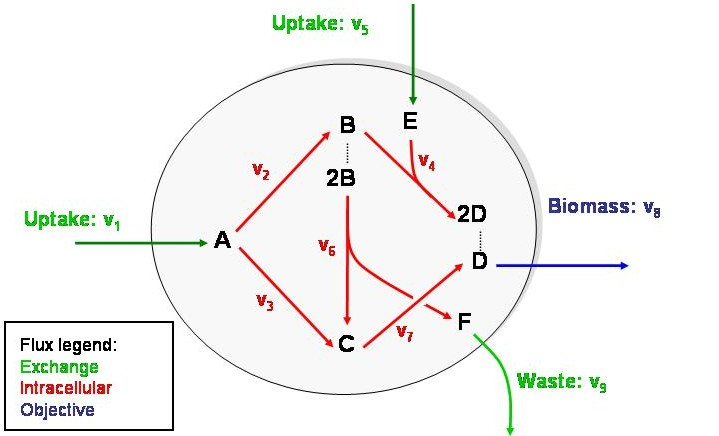

In [2]:
import mentos
from IPython.display import Image, display
import sys
from scipy.stats import entropy
import numpy as np
import cvxpy as cvx
import pandas as pd
import sys, cobra, re
from IPython.display import display, HTML
#import pandas.core.format as fmt
pd.options.display.float_format = '{:.3g}'.format 
#pd.options.display.float_+ormat = '{:.0f}'.format

pd.options.display.float_format = '{:.3g}'.format

reactions = {}
metab = {}

def print_report( report_dir, out_template, df ):
    nonalphanumRE = re.compile(r'[^A-Za-z0-9_]')
    if not os.path.isdir(report_dir):
        os.mkdir(report_dir)
    for c in df.columns:
        df[c].to_csv(os.path.join(report_dir,out_template.format(nonalphanumRE.sub('_', c))),header=True)

Image('Metabolic-network.JPG')

## Maximize macroscopic entropy production rate with steady state constraint for net likelihoods for the ABC model ##

$$ \begin{array}{ll}
    \underset{\vec{\bf r}_+,\vec{\bf r}_-,\vec{\bf c}}{\mbox{maximize}}   & - \sum_j\left({\mathscr P}_{+j}\log({\mathscr P}_{+j}) + {\mathscr P}_{-j}\log({\mathscr P}_{-j})\right)\cdot v_{growth}   \\
    \mbox{subject to}  & S\cdot(\vec{\bf L}_+-\vec{\bf L}_-) = 0 \\
                         & S\cdot(\vec{\bf r}_+-\vec{\bf r}_-) = 0 \\
                       &\log\vec{\bf r}_+ -\log\vec{\bf r}_-= -\frac{1}{RT}S^T\cdot\vec{\mu}^0 - S^T\cdot\log\vec{\bf c} \\
                      %% & \log\vec{\bf L}_- = \frac{1}{RT}S^T\cdot\vec{\mu}^0 + S^T\cdot\log\vec{\bf c} \\
                      %% & \log\vec{\bf L}_+  -\log\vec{\bf L}_- \\
                     %% & \vec{v}_{lower}(L_+) \leq \vec{\bf r}_+ -\vec{\bf r}_- \leq \vec{v}_{upper}(L_+) \\
                         & \vec{\bf r}_+ \geq 0 \\
    & \vec{\bf r}_- \geq 0 \\
                      & \log \left[{\bf A}_{ext}\right] = \log \left[{\bf E}_{ext}\right] =  \log c_{upper} \\
                      & \log \left[{\bf E}_{ext}\right] = \log \left[{\bf D}_{ext}\right] = \log c_{lower}   \\         
      & -\left|\Delta G_{ext}\right| \leq S^T\mu \leq \left|\Delta G_{ext}\right|
    \end{array} 
$$

Where
* $\vec{\bf r}_+,\vec{\bf r}_-$ are decision variables representing the forward and backward rates, respectively.
* ${\mathscr P}_{+i},{\mathscr P}_{-i}$ are the normalized forward and backward thermodynamic driving forces $\frac{r_{+i}}{r_{-i}}\left(\sum_j\frac{r_{+j}}{r_{-j}} + \frac{r_{-j}}{r_{+j}}\right)^{-1}$ and $\frac{r_{-i}}{r_{+i}}\left(\sum_j\frac{r_{+j}}{r_{-j}} + \frac{r_{-j}}{r_{+j}}\right)^{-1}$
* $\vec{\bf c}$ is a decision variable representing the chemical concentrations of each metabolite 
*  $S$ is the $m\times n$ stoichiometric matrix of representing $m$ metabolites and $n$ reactions of the model  
*  $\vec{\mu}^0$ is the vector of standard chemical potentials 
* $L_+ = \frac{r_+}{r_-}$
* $L_- = \frac{r_-}{r_+}$
* $v_{lower}(L) =\min\left(-1,\text{sign}(\log L)\cdot L^{\text{sign}(\log L)}\right) + 1$
* $v_{upper}(L) = \max\left(1,\text{sign}(\log L)\cdot L^{\text{sign}(\log L)}\right) - 1$
* $\Delta G_{ext} =  \mu_{D_{ext}} + \mu_{F_{ext}} - \mu_{A_{ext}} - \mu_{E_{ext}}$

Decision variables are emphasized in **bold**. 

In [11]:
from mentos.abc_model import fullS, S, deltaG0, mu0, \
     c_U, c_L, mets, external_mets, met_bounds, internal_mets, rxns, \
     efflux, uptake, n, m, R, T, biomass, \
     external_free_energy, efflux, uptake, A_ext, D_ext, E_ext, F_ext
import sys
import mentos
import pandas as pd
import cobra.core

sys.path.append('/Users/kuma889/src')
abc_dir = ''
from myefm import calculate_elementary_modes, calculate_minimum_cut_sets
algorithm = 'convex_mentos_likelihoods_first_elmo'
problem = {}
#met_bounds = mentos.getMetBounds(fullS, fluxes, c_L, c_U)
log_c = cvx.Variable(m)                                     # log of the concentrations
log_likelihood = cvx.Variable(n)

log_Q = fullS.as_matrix().T*log_c                              # log of the Reaction quotient
log_K = cvx.Constant(-1.0/(R*T)*deltaG0.as_matrix())           # log of the Equilibrium constnat
mu = R*T*log_c + mu0.values
#positive_flux_constraint = [log_likelihood[rxn]  >= 0 
#                                for rxn in range(len(rxns)) 
#                                    if unbiased_flux[rxn] >= 0]

#negative_flux_con
#straint = [log_likelihood[rxn] <= 0 for rxn in range(len(rxns)) if unbiased_flux[rxn] <= 0]

#obj = cvx.Maximize(cvx.sum_entries(cvx.entr(log_likelihood)))  # entropy of the log likelihoods
obj  = cvx.Minimize(cvx.norm2(log_likelihood))
constraints = [log_likelihood == log_K - log_Q,
              log_c[A_ext] == cvx.log(c_U),             # Creating a concentration gradient between A, E and D,F
              log_c[E_ext] == cvx.log(c_U),
              log_c[D_ext] == cvx.log(c_L),
              log_c[F_ext] == cvx.log(c_L),
             
              -abs(external_free_energy) <= fullS.T.as_matrix()*mu,
              fullS.T.as_matrix()*mu <= abs(external_free_energy)
              ] #+ positive_flux_constraint + negative_flux_constraint
cvx.Problem(obj, constraints).solve()

v_L, v_U = mentos.get_rxn_bounds_from_log_likelihood( log_likelihood )
v_L, v_U

import sys, os
sys.path.append('/Users/zuck016/Projects/src')
from myefm import calculate_elementary_modes, calculate_minimum_cut_sets

#abc_dir = os.path.join(os.environ['HOME'], 'Projects/CRT','Mentos/ABC')
model_name = os.path.join(abc_dir,'ABC_model.json')
abc = cobra.io.load_json_model( model_name )
abc.remove_metabolites([met for met in abc.metabolites if '_ext' in met.id])
for j, rxn in enumerate(abc.reactions):
    rxn.lower_bound = v_L[j]
    rxn.upper_bound = v_U[j]

abc_efms = calculate_elementary_modes(abc, verbose=False)
abc_efms = abc_efms.T.divide(abc_efms['R_1']).T
display(abc_efms)
unbiased_flux = abc_efms.sum(axis=0)/abc_efms['R_1'].sum()
unbiased_flux.to_frame('Unbiased flux')



#v = cvx.Variable(n)
#obj = cvx.Maximize(v[biomass])
#constraints = [S*v == 0,
#              v_L <= v,
#              v <= v_U]
#cvx.Problem(obj, constraints).solve()

forward_rate,backward_rate = mentos.get_rates_from_log_likelihood_and_flux(  log_likelihood, unbiased_flux.values )
metab[algorithm] = mentos.generate_metabolite_report( np.squeeze(np.asarray(log_c.value))
                                                             , forward_rate, backward_rate, S, mets, internal_mets, rxns, fullS,
                                                             mu0,).astype(np.float64)
#display(mentos.compare_frames(**metab))
display(HTML(metab[algorithm].T.to_html()))
reactions[algorithm] = mentos.generate_rxn_report(mets, log_c, log_Q.value, log_K.value,
                                                         forward_rate, backward_rate, rxns, deltaG0,'R_8')
#display(mentos.compare_frames(**reactions))
display(HTML(reactions[algorithm].T.to_html()))
mentos.print_report( os.path.join(abc_dir, algorithm), 'ABC_metab_{}.csv', metab[algorithm] )
mentos.print_report( os.path.join(abc_dir, algorithm), 'ABC_reaction_{}.csv', reactions[algorithm])

#display(HTML(reactions[algorithm].to_html()))

ImportError: No module named myefm

In [4]:
pwd

u'/Users/kuma889/Projects/Boltzmann/MENTOS/ABC-model-mentos'

In [11]:
import escher,os
import os
import sys
import mentos
import pandas as pd
import cobra.core

from mentos.abc_model import fullS, S, deltaG0, mu0, \
     c_U, c_L, mets, external_mets, met_bounds, internal_mets, rxns, \
     efflux, uptake, n, m, R, T, biomass, \
     external_free_energy, efflux, uptake, A_ext, D_ext, E_ext, F_ext, \
     v_L, v_U
from scipy.stats import entropy
obj = 'macro_maxent_production_rate_pyOpt_optimize_w_scipy_entropy'
convex_mentos = 'convex_mentos_likelihoods_first_elmo'
metab[convex_mentos]=pd.read_table(os.path.join(convex_mentos, "ABC_metab_{}.csv".format(convex_mentos)), index_col=0)
display(metab[convex_mentos])

reactions[convex_mentos]=pd.read_table(os.path.join(convex_mentos, "ABC_reaction_{}.csv".format(convex_mentos)), index_col=0)
display(reactions[convex_mentos])

boltzmann= 'boltzmann'
metab[boltzmann]=pd.read_table(os.path.join(boltzmann, "ABC_metab_{}.csv".format(convex_mentos)), index_col=0)
display(metab[boltzmann])

#true_metab[obj] = pd.read_csv('ABC_metab_{}.csv'.format(obj), index_col=0).astype(np.float64)
#true_reactions[obj] = pd.read_csv('ABC_reactions_{}.csv'.format(obj),index_col=0)

m,n = fullS.shape
i,n = S.shape
variable_group = [dict(name='log_c',nvars=m, type='c',
                                     initial_value=metab[convex_mentos]['Log Concentrations'].values),
                      dict(name='forward_rate', nvars=n, type='c',
                                             initial_value=reactions[convex_mentos]['Forward rate'].values),
                      dict(name='backward_rate',nvars=n, type='c',
                                            initial_value=reactions[convex_mentos]['Backward rate'].values)]
constraint_group=[#dict(name='steady_state_net_likelihood', ncons=i, type='e'),
                    dict(name='steady_state_flux', ncons=i, type='e'),
                    dict(name='thermodynamics',ncons=n, type='e'),
                    dict(name='boundary_conditions', ncons=m-i, type='e'),
                    dict(name='energy_barrier', ncons=n, type='i'),
                    dict(name='energy_sink',ncons=n,type='i'),
                    dict(name='flux_lower_bounds', ncons=n, type='i'),
                    dict(name='flux_upper_bounds', ncons=n,type='i')]
def make_macro_maxent_production_rate_objective(fullS, S, mu0, deltaG0, R, T, c_L, c_U,v_L, v_U):
    external_mets = [met for met in fullS.index if 'ext' in met]
    met_bounds = pd.Series({'A_ext':c_U, 'E_ext': c_U, 'F_ext': c_L, 'D_ext': c_L}, index=external_mets)
    mu_ext = mu0[external_mets] + R*T*met_bounds.apply(np.log)
    external_free_energy =  (mu_ext['D_ext'] + mu_ext['F_ext']) - (mu_ext['A_ext'] + mu_ext['E_ext'])
    
    def macro_maxent_production_rate(x):
        """Maximize product of  entropy production and macroscopic biomass growth rate of the ABC model"""
        log_c, \
        forward_rate, backward_rate, \
        log_Q, log_K, \
        forward_likelihood, backward_likelihood, \
        forward_probability, backward_probability, mu, \
        thermodynamic_driving_force, \
        net_flux = mentos.make_variables( x, fullS, mu0, deltaG0, R, T )
        f = entropy( np.concatenate( ( forward_probability, backward_probability ) ) )*net_flux[biomass]
        g = np.concatenate((#np.dot(S,forward_likelihood - backward_likelihood),
                            np.dot(S,net_flux),
                            np.log(forward_rate) - np.log(backward_rate) + log_Q - log_K,
                            [ log_c[A_ext] - np.log(c_U),  # = 0               # Creating a concentration gradient between A, E and D,F
                              log_c[E_ext] - np.log(c_U),  # = 0
                              log_c[D_ext] - np.log(c_L),  # = 0
                              log_c[F_ext] - np.log(c_L)],  #= 0
                            -abs(external_free_energy) - np.dot(fullS.T.as_matrix(),mu), # <= 0
                            np.dot(fullS.T.as_matrix(),mu) - abs(external_free_energy),  # <= 0 
                            np.minimum(-1, thermodynamic_driving_force)+ 1 -net_flux, # <= 0
                            net_flux - np.maximum(1, thermodynamic_driving_force ) - 1)) # <= 0
        
        fail = 0
        return -f, g, fail
    return macro_maxent_production_rate
metab[obj], reactions[obj] = mentos.run_mentos_ext_free_energy(fullS, S, internal_mets, deltaG0, mu0, 
                                        variable_group, constraint_group,
                                        obj=make_macro_maxent_production_rate_objective( fullS, S, mu0, deltaG0, R, T, c_L, c_U,v_L, v_U),
                                        biomass_rxn='R_8')

algorithm = obj
mentos.print_report( os.path.join(abc_dir, algorithm), 'ABC_metab_{}.csv', metab[algorithm] )
mentos.print_report( os.path.join(abc_dir, algorithm), 'ABC_reaction_{}.csv', reactions[algorithm])

display(metab[obj].T)
                             
display(reactions[obj].T)

,Counts,Concentrations,Log Concentrations,Standard Chemical potential,Chemical potential,Normalized Concentrations,Absolute activities,Normalized absolute activities,Entropy,Entropy of Concentrations,fullS*forward_rate,fullS*backward_rate,fullS*net_flux,fullS*net_likelihood,fullS*net_probabilities
A,4.22e+03,7.01e-06,-11.9,0,-29.4,0.00327,1.67e-13,4.02e-06,4.99e-05,0.0187,-0.46,-0.46,0,58.9,0.0934
B,114,1.9e-07,-15.5,-2,-40.4,8.87e-05,2.95e-18,7.09e-11,1.66e-09,0.000828,-0.192,-0.192,0,68.8,0.109
C,5.48e+03,9.09e-06,-11.6,-2,-30.8,0.00425,4.31e-14,1.04e-06,1.43e-05,0.0232,0.424,0.424,0,-1.28,-0.00203
D,2.25e+03,3.73e-06,-12.5,-4,-35,0.00174,6.42e-16,1.54e-08,2.78e-07,0.0111,0.201,0.201,-2.22e-16,-352,-0.558
E,7.28e+04,0.000121,-9.02,-2,-24.4,0.0565,2.63e-11,0.000633,0.00466,0.162,4.53e-07,4.53e-07,0,-7.28e-05,-1.16e-07
F,19,3.16e-08,-17.3,-10,-52.8,1.48e-05,1.16e-23,2.79e-16,1e-14,0.000164,-5.88e-07,-5.88e-07,-2.78e-17,1.81e-05,2.87e-08
A_ext,6.02e+05,0.001,-6.91,0,-17.1,0.467,3.66e-08,0.88,0.112,0.356,-1.01,-0.00706,-1,-143,-0.226
D_ext,6,1e-08,-18.4,-4,-49.7,4.67e-06,2.7e-22,6.5e-15,2.12e-13,5.73e-05,1.17,0.00313,1.17,373,0.592
E_ext,6.02e+05,0.001,-6.91,-2,-19.1,0.467,4.95e-09,0.119,0.253,0.356,-0.379,-0.0458,-0.333,-8.15,-0.0129
F_ext,6,1e-08,-18.4,-10,-55.7,4.67e-06,6.69e-25,1.61e-17,6.23e-16,5.73e-05,0.244,0.0771,0.167,2.85,0.00451


,Forward likelihoods,Backward likelihoods,Delta G,log Q_r,log K_eq,Delta G0,logK - logQ,logQ - logK,Forward Log likelihoods,Backward Log likelihoods,...,Net Reaction Entropy Production,Microscopic Reaction Entropy Production Rate,Microscopic Reaction Entropy Production Net Flux,Microscopic Reaction Entropy Production Net Flux Difference,Total Entropy Production,Total Microscopic Entropy Production Rate,Macroscopic Reaction Entropy Production Net Flux,Macroscopic Reaction Entropy Production Net Flux Difference,Total Macroscopic Entropy Production Net Flux,Total Macroscopic Entropy Production Net Flux Difference
R_1,143,0.00701,-12.3,-4.96,-0,0,4.96,-4.96,4.96,-4.96,...,0.336,0.339,0.336,0.336,1.16,0.955,0.392,0.392,1.35,1.3
R_2,82.7,0.0121,-10.9,-3.61,0.807,-2,4.41,-4.41,4.41,-4.41,...,0.266,0.18,0.178,0.177,1.16,0.955,0.311,0.311,1.35,1.3
R_3,1.73,0.579,-1.35,0.261,0.807,-2,0.546,-0.546,0.546,-0.546,...,0.00973,0.0157,0.00753,0.00324,1.16,0.955,0.0263,0.0114,1.35,1.3
R_4,8.27,0.121,-5.24,-0.499,1.61,-4,2.11,-2.11,2.11,-2.11,...,0.0552,0.0216,0.0195,0.0184,1.16,0.955,0.0682,0.0644,1.35,1.3
R_5,8.27,0.121,-5.24,-2.11,-0,0,2.11,-2.11,2.11,-2.11,...,0.0552,0.0216,0.0195,0.0184,1.16,0.955,0.0682,0.0644,1.35,1.3
R_6,3.16,0.316,-2.85,2.08,3.23,-8,1.15,-1.15,1.15,-1.15,...,0.0227,0.00677,0.00506,0.00379,1.16,0.955,0.0354,0.0265,1.35,1.3
R_7,5.46,0.183,-4.21,-0.89,0.807,-2,1.7,-1.7,1.7,-1.7,...,0.0388,0.0254,0.0217,0.0194,1.16,0.955,0.0507,0.0452,1.35,1.3
R_8,373,0.00268,-14.7,-5.92,-0,0,5.92,-5.92,5.92,-5.92,...,0.31,0.363,0.362,0.362,1.16,0.955,0.362,0.362,1.35,1.3
R_9,3.16,0.316,-2.85,-1.15,-0,0,1.15,-1.15,1.15,-1.15,...,0.0227,0.00677,0.00506,0.00379,1.16,0.955,0.0354,0.0265,1.35,1.3


IOError: File boltzmann/ABC_metab_convex_mentos_likelihoods_first_elmo.csv does not exist

In [19]:
import mentos
import pandas as pd, os, sys
import numpy as np
from mentos.abc_model import fullS, S, deltaG0, mu0, \
     c_U, c_L, mets, external_mets, met_bounds, internal_mets, rxns, \
     efflux, uptake, n, m, R, T, biomass, \
     external_free_energy, efflux, uptake, A_ext, D_ext, E_ext, F_ext, \
     v_L, v_U
from scipy.stats import entropy
from IPython.display import display, Markdown, Latex, SVG, Image, HTML
abc_dir = ''
metab, reactions = {}, {}

convex_mentos = 'convex_mentos_likelihoods_first_elmo'
metab[convex_mentos] = pd.read_table(os.path.join(convex_mentos, 'ABC_metab_{}.csv'.format(convex_mentos)), index_col=0)
#display(metab[convex_mentos])

boltzmann = 'boltzmann'
metab[boltzmann] = pd.read_table(os.path.join(boltzmann, 'ABC_metab_{}.csv'.format(boltzmann)), index_col=0)
#display(metab[convex_mentos])

reactions[convex_mentos] = pd.read_table(os.path.join(convex_mentos, 'ABC_reaction_{}.csv'.format(convex_mentos)), index_col=0)
reactions[boltzmann] = pd.read_table(os.path.join(boltzmann, 'ABC_reaction_{}.csv'.format(boltzmann)), index_col=0)
#display(reactions[convex_mentos])

display(metab[obj].T)
                             
display(reactions[obj].T)

m,n = fullS.shape
i,n = S.shape


def macroscopic_entropy_production_rate( x, fullS, mu0, deltaG0, R, T ):
    log_c, \
    forward_rate, backward_rate, \
    log_Q, log_K, \
    forward_likelihood, backward_likelihood, \
    forward_probability, backward_probability, mu, \
    thermodynamic_driving_force, \
    net_flux = mentos.make_variables( x, fullS, mu0, deltaG0, R, T )
    return entropy( np.concatenate( ( forward_probability, backward_probability ) ) )*net_flux[biomass]

def all_constraints( x, fullS, mu0, deltaG0, R, T  ):
    log_c, \
    forward_rate, backward_rate, \
    log_Q, log_K, \
    forward_likelihood, backward_likelihood, \
    forward_probability, backward_probability, mu, \
    thermodynamic_driving_force, \
    net_flux = mentos.make_variables( x, fullS, mu0, deltaG0, R, T )
    return np.concatenate((np.dot(S,forward_likelihood - backward_likelihood),
                            np.dot(S,net_flux),
                            np.log(forward_rate) - np.log(backward_rate) + log_Q - log_K,
                            [ log_c[A_ext] - np.log(c_U),  # = 0               # Creating a concentration gradient between A, E and D,F
                              log_c[E_ext] - np.log(c_U),  # = 0
                              log_c[D_ext] - np.log(c_L),  # = 0
                              log_c[F_ext] - np.log(c_L)],  #= 0
                            -abs(external_free_energy) - np.dot(fullS.T.as_matrix(),mu), # <= 0
                            np.dot(fullS.T.as_matrix(),mu) - abs(external_free_energy),  # <= 0 
                            np.minimum(-1, thermodynamic_driving_force)+ 1 -net_flux, # <= 0
                            net_flux - np.maximum(1, thermodynamic_driving_force ) - 1)
                           ) # <= 0

def thermo_and_boundary( x, fullS, mu0, deltaG0, R, T ):
    log_c, \
    forward_rate, backward_rate, \
    log_Q, log_K, \
    forward_likelihood, backward_likelihood, \
    forward_probability, backward_probability, mu, \
    thermodynamic_driving_force, \
    net_flux = mentos.make_variables( x, fullS, mu0, deltaG0, R, T )
    return np.concatenate((np.log(forward_rate) - np.log(backward_rate) + log_Q - log_K,
                           [  log_c[A_ext] - np.log(c_U),  # = 0               # Creating a concentration gradient between A, E and D,F
                              log_c[E_ext] - np.log(c_U),  # = 0
                              log_c[D_ext] - np.log(c_L),  # = 0
                              log_c[F_ext] - np.log(c_L)]))  #= 0)
def make_macro_maxent_production_rate_objective(fullS, S, mu0, deltaG0, R, T, c_L, c_U,v_L, v_U, objective_function, constraint_function):
    external_mets = [met for met in fullS.index if 'ext' in met]
    met_bounds = pd.Series({'A_ext':c_U, 'E_ext': c_U, 'F_ext': c_L, 'D_ext': c_L}, index=external_mets)
    mu_ext = mu0[external_mets] + R*T*met_bounds.apply(np.log)
    external_free_energy =  (mu_ext['D_ext'] + mu_ext['F_ext']) - (mu_ext['A_ext'] + mu_ext['E_ext'])
    
    def macro_maxent_production_rate(x):
        """Maximize product of  entropy production and macroscopic biomass growth rate of the ABC model"""
        f = objective_function( x, fullS, mu0, deltaG0, R, T  )
        g = constraint_function( x, fullS, mu0, deltaG0, R, T )
        fail = 0
        return -f, g, fail
    return macro_maxent_production_rate

KeyError: 'macro_maxent_production_rate_pyOpt_optimize_w_scipy_entropy'

In [17]:

variable_group = {'rates_and_log_c':[  
                    dict(name='log_c',nvars=m, type='c', initial_value=metab[convex_mentos]['Log Concentrations'].values),
                    dict(name='forward_rate', nvars=n, type='c', initial_value=reactions[convex_mentos]['Forward rate'].values),
                    dict(name='backward_rate',nvars=n, type='c', initial_value=reactions[convex_mentos]['Backward rate'].values)],
                 'likelihoods_and_log_c': [
                    dict(name='forward_likelihood', nvars=n, type='c', initial_value=reactions[convex_mentos]['Forward likelihoods'].values),
                    dict(name='forward_likelihood', nvars=n, type='c', initial_value=reactions[convex_mentos]['Forward likelihoods'].values),
                    dict(name='log_c',nvars=m, type='c', initial_value=metab[convex_mentos]['Log Concentrations'].values)]}
       
constraint_group={'all_constraints':[
                    dict(name='steady_state_net_likelihood', ncons=i, type='e'),
                    dict(name='steady_state_flux', ncons=i, type='e'),
                    dict(name='thermodynamics',ncons=n, type='e'),
                    dict(name='boundary_conditions', ncons=m-i, type='e'),
                    dict(name='energy_barrier', ncons=n, type='i'),
                    dict(name='energy_sink',ncons=n,type='i'),
                    dict(name='flux_lower_bounds', ncons=n, type='i'),
                    dict(name='flux_upper_bounds', ncons=n,type='i')],
                  'thermo_and_boundary':[dict(name='thermodynamics',ncons=n, type='e'),
                                         dict(name='boundary_conditions', ncons=m-i, type='e'),]}
constraint_function = {'all_constraints': all_constraints,
                      'thermo_and_boundary': thermo_and_boundary}


for cg in constraint_group:
    metab[cg], reactions[cg] = mentos.run_mentos_ext_free_energy(fullS, S, internal_mets, deltaG0, mu0, 
                                        variable_group['rates_and_log_c'], constraint_group[cg],
                                        obj=make_macro_maxent_production_rate_objective( fullS, S, mu0, deltaG0, R, T, c_L, c_U,v_L, v_U, 
                                                                                         objective_function=macroscopic_entropy_production_rate,
                                                                                         constraint_function=constraint_function[cg]),
                                        biomass_rxn='R_8')
    mentos.print_report( os.path.join(abc_dir, cg), 'ABC_metab_{}.csv', metab[cg] )
    mentos.print_report( os.path.join(abc_dir, cg), 'ABC_reaction_{}.csv', reactions[cg])
    #display(Markdown('### ' + cg))
    #display(metab[cg].T)
                             
    
    #display(reactions[cg].T)
display(HTML(mentos.compare_frames(**metab).to_html()))

display(HTML(mentos.compare_frames(**reactions).to_html()))

AttributeError: 'module' object has no attribute 'print_report'